### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from math import pi as PI
from scipy import stats
from sklearn import datasets
from sklearn.impute import KNNImputer
from sklearn.datasets import fetch_openml
from collections import OrderedDict
# evaluation
from sklearn import neighbors 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from random import randint
from scipy.stats import boxcox
from sklearn.neighbors import KNeighborsClassifier
from scipy import interp

# models
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_curve, auc, mean_squared_error, confusion_matrix, plot_confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate , RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

# pre processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA

warnings.filterwarnings('ignore')

### Data Exploration

In [2]:
# readin the train and test data from csv
data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

X, y = data.values[:,:-1], data.values[:, -1]
print(f'X.shape: {X.shape}, y.shape: {y.shape}')
data.head()

X.shape: (10479, 22), y.shape: (10479,)


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase
0,0,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,...,1.0,safari_15,1.0,Returning_Visitor,False,c_1,118.880094,log202,NaN,0
1,1,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,0.000000,0.200000,0.200000,...,4.0,safari_14,9.0,Returning_Visitor,False,c_3,113.358423,log404,NaN,0
2,2,0.0,0.0,0.0,NaN,NaN,627.5 minutes,627.500000,0.020000,0.050000,...,3.0,browser_3_v17,1.0,Returning_Visitor,True,c_4,121.507695,log202,NaN,0
3,3,0.0,0.0,0.0,0.0 minutes,19.0,154.2166667 minutes,154.216667,0.015789,0.024561,...,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_3,93.747176,log_100,NaN,0
4,4,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,...,2.0,edge_96.0.1054.75,3.0,Returning_Visitor,False,c_3,99.545824,log202,NaN,0


### Split Data

Before we start with visualization,
we will split the data to numeric features and category features.
In numeric data we will drop the "id" column, and since the columns "device","Region" and "purchase" are considered categorical but have numerical value, we will move them to the categorical data.

### Functions for the exploration part - 

In [3]:
def split_data(data):
    if 'id' in data:
        data.drop(columns='id', inplace=True)
    data_numeric = data.select_dtypes(include=['float64' , 'int64','int32']).copy()
    if 'device' in data_numeric:
        data_numeric.drop(columns='device', inplace=True)
    if 'Region' in data:
        data_numeric.drop(columns='Region', inplace=True)
    if 'purchase' in data:
        data_numeric.drop(columns='purchase', inplace=True)
   


    data_category = data.select_dtypes(include=[np.object_])
    if 'device' in data:
      data_category['device'] = data['device'] 
    if 'Region' in data:  
      data_category['Region'] = data['Region']
    if 'purchase' in data:
      data_category['purchase'] = data['purchase']
    return data_numeric, data_category


def heatmap(data):
    corr_of_f = data.corr()
    mask = np.zeros_like(corr_of_f, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    plt.subplots(figsize=(13,9))
    cmap = sns.diverging_palette(230, 354, as_cmap=True)
    sns.heatmap(data.corr(),mask=mask, cmap=cmap,annot=round(data.corr(),2),
                xticklabels=data.corr().columns,
                yticklabels=data.corr().columns, linewidths=0.06, linecolor='white')
    plt.show()
    

def clean_browser(data):
    # replace all valuse that contain one of the names chrome,safari,esde or browser to create only 4 uniq values 
    data_browser = data.copy()
    data_browser.loc[data_browser['internet_browser'].str.contains('chrome' , na = False), 'internet_browser'] = 'chrome'

    data_browser.loc[data_browser['internet_browser'].str.contains('safari' , na = False), 'internet_browser'] = 'safari'

    data_browser.loc[data_browser['internet_browser'].str.contains('edge' , na = False), 'internet_browser'] = 'edge'

    data_browser.loc[data_browser['internet_browser'].str.contains('browser' , na = False), 'internet_browser'] = 'browser_v'
    return data_browser


#### NAN count for every feature-

In [4]:
data.isnull().sum()

id                           0
num_of_admin_pages         605
admin_page_duration        413
num_of_info_pages          687
info_page_duration         317
num_of_product_pages       403
product_page_duration      621
total_duration            4753
BounceRates                 22
ExitRates                   26
PageValues                  27
closeness_to_holiday       496
Month                       25
device                     323
internet_browser           563
Region                      19
user_type                   23
Weekend                     23
A                          706
B                           23
C                           23
D                        10374
purchase                     0
dtype: int64

#### Number of uniqe values for every feature-

In [5]:
data.nunique()

id                       10479
num_of_admin_pages          26
admin_page_duration       2855
num_of_info_pages           17
info_page_duration        1089
num_of_product_pages       292
product_page_duration     7803
total_duration            4811
BounceRates               1645
ExitRates                 4148
PageValues                2296
closeness_to_holiday         6
Month                       10
device                       8
internet_browser           126
Region                       9
user_type                    3
Weekend                      2
A                           96
B                        10456
C                            6
D                          105
purchase                     2
dtype: int64

Bar plot to see the distribution of the label (1 and 0)

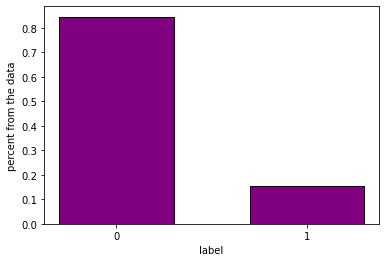

The number of observations :  10479
The number of observations with class 0 : 8858 0.8453096669529535%
The number of observations with class 1 :  1621 0.15469033304704646%


In [6]:
#Calculates the percentage of each label
num_0 = data["purchase"].value_counts()[0]/float(data.shape[0]) 
num_1 = data["purchase"].value_counts()[1]/float(data.shape[0])
#creating plot 
plt.bar(['0','1'], [num_0,num_1], width =0.6, color='purple',edgecolor='black')
plt.xlabel('label')
plt.ylabel('percent from the data')
plt.show()

print ("The number of observations : ", data.shape[0])
print ("The number of observations with class 0 :", data["purchase"].value_counts()[0] , str(num_0) + '%')
print ("The number of observations with class 1 : ", data["purchase"].value_counts()[1], str(num_1) + '%')

## Numeric features

### Conversion to numeric columns 
The columns "info_page_duration" and "product_page_duration" represent minutes, meaning they are numeric columns.
Therefore, we will apply the following changes in order to get numerical values before dealing with numeric features 

In [7]:
# removing 'minutes' from all values in  info_page_duration and product_page_duration and converting values to floats after 
def data_rep(data):

    data['info_page_duration'] = data['info_page_duration'].str.replace('minutes','')
    data['product_page_duration'] = data['product_page_duration'].str.replace('minutes','')
    data['info_page_duration'] = data['info_page_duration'].astype(float)
    data['product_page_duration'] = data['product_page_duration'].astype(float)

data_rep(data)
data_rep(test_data)

data.head()

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase
0,0,0.0,0.0,0.0,0.0,1.0,0.000000,NaN,0.200000,0.200000,...,1.0,safari_15,1.0,Returning_Visitor,False,c_1,118.880094,log202,NaN,0
1,1,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.200000,0.200000,...,4.0,safari_14,9.0,Returning_Visitor,False,c_3,113.358423,log404,NaN,0
2,2,0.0,0.0,0.0,NaN,NaN,627.500000,627.500000,0.020000,0.050000,...,3.0,browser_3_v17,1.0,Returning_Visitor,True,c_4,121.507695,log202,NaN,0
3,3,0.0,0.0,0.0,0.0,19.0,154.216667,154.216667,0.015789,0.024561,...,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_3,93.747176,log_100,NaN,0
4,4,0.0,0.0,0.0,0.0,1.0,0.000000,NaN,0.200000,0.200000,...,2.0,edge_96.0.1054.75,3.0,Returning_Visitor,False,c_3,99.545824,log202,NaN,0


#### statistic summary of the data 

In [8]:
data_numeric, data_category=split_data(data)
test_data_numeric, test_data_category=split_data(test_data)
data_numeric.describe()

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,B,D
count,9874.000000,10066.000000,9792.000000,10162.000000,10076.000000,9858.000000,5726.000000,10457.000000,10453.000000,10452.000000,9983.000000,10456.000000,105.000000
mean,2.321957,80.462468,0.502655,34.323813,31.870187,1197.518516,1302.457216,0.021854,0.042859,5.900387,0.061985,99.769628,4.060440
std,3.335331,179.217548,1.265812,142.039051,44.816259,1954.950012,2039.312905,0.048100,0.048297,18.727496,0.199429,10.050268,2.189818
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.733919,-1.235571
25%,0.000000,0.000000,0.000000,0.000000,7.000000,183.500000,221.000000,0.000000,0.014283,0.000000,0.000000,93.030568,3.141657
50%,1.000000,8.000000,0.000000,0.000000,18.000000,598.441667,677.851191,0.002968,0.025161,0.000000,0.000000,99.787249,4.432221
75%,4.000000,93.000000,0.000000,0.000000,38.000000,1470.302083,1605.733333,0.016667,0.050000,0.000000,0.000000,106.506626,5.531061
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,47850.920680,0.200000,0.200000,361.763742,1.000000,141.735142,7.618254


##  Now let's check the correlation between the Features

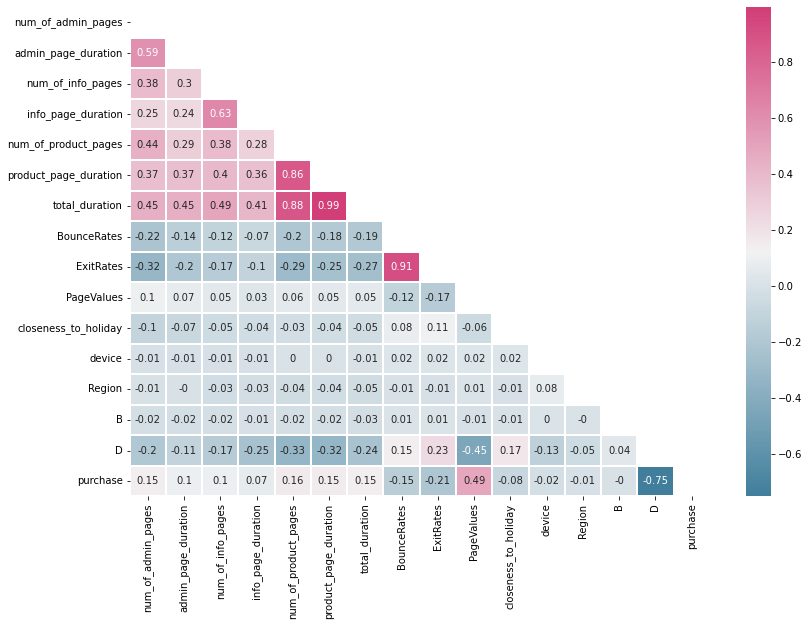

In [9]:
heatmap(data)

Conclusion: BounceRates & ExitRates, total_duration & num_of_product_pages, product_page_duration & num_of_prodauct_pages have high correlation, as well as D and and purchase! 

### Let's see how our numeric features are distributed using distribution plots - 
We will also that not all the  features are plottable this way, and we will deal with those later.

array([[<AxesSubplot:title={'center':'num_of_admin_pages'}>,
        <AxesSubplot:title={'center':'admin_page_duration'}>,
        <AxesSubplot:title={'center':'num_of_info_pages'}>,
        <AxesSubplot:title={'center':'info_page_duration'}>],
       [<AxesSubplot:title={'center':'num_of_product_pages'}>,
        <AxesSubplot:title={'center':'product_page_duration'}>,
        <AxesSubplot:title={'center':'total_duration'}>,
        <AxesSubplot:title={'center':'BounceRates'}>],
       [<AxesSubplot:title={'center':'ExitRates'}>,
        <AxesSubplot:title={'center':'PageValues'}>,
        <AxesSubplot:title={'center':'closeness_to_holiday'}>,
        <AxesSubplot:title={'center':'B'}>],
       [<AxesSubplot:title={'center':'D'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

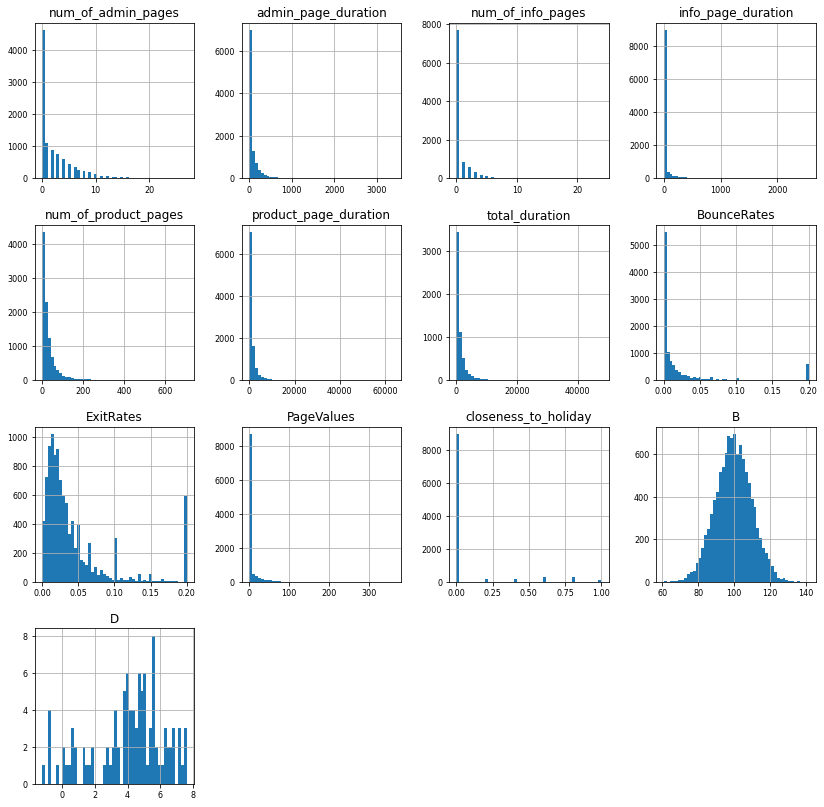

In [10]:
data_numeric.hist(figsize=(14, 14), bins=50, xlabelsize=8, ylabelsize=8)

As it seem from the plot above, the feature B looks like a near perfect gausion distribution, and some of the other features looks relativly close to a log-normal/similre to a gaussian.

## Categorial & Binary Columns

In [11]:
data.describe(include=np.object)  

,Month,internet_browser,user_type,Weekend,A,C
count,10454,9916,10456,10456,9773,10456
unique,10,126,3,2,96,6
top,May,chrome_89,Returning_Visitor,False,c_2,log200
freq,2857,1117,8956,8041,3101,1813


### Histogram
Let's see the visualization of the categories in each categorical feature

Feature number: Month


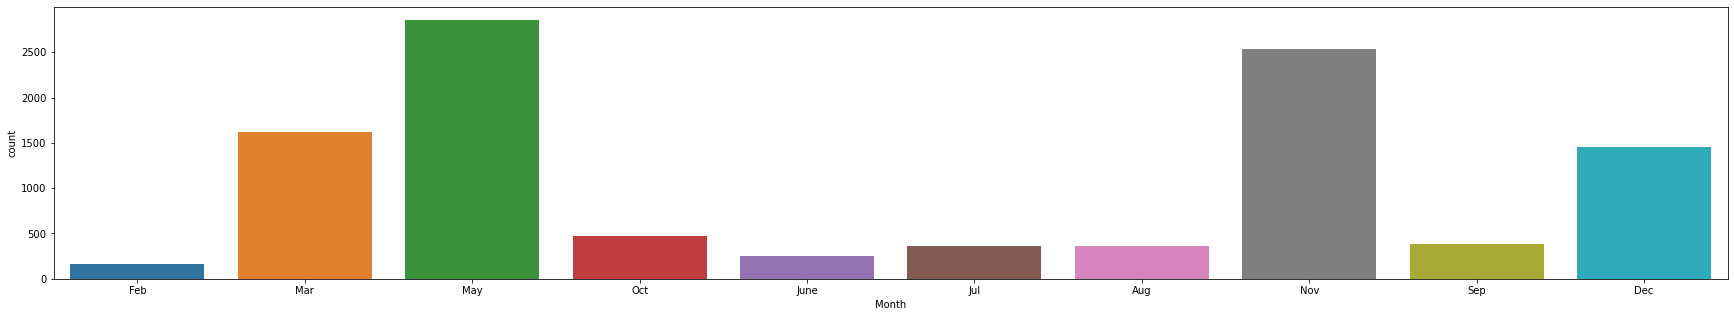

Feature number: internet_browser


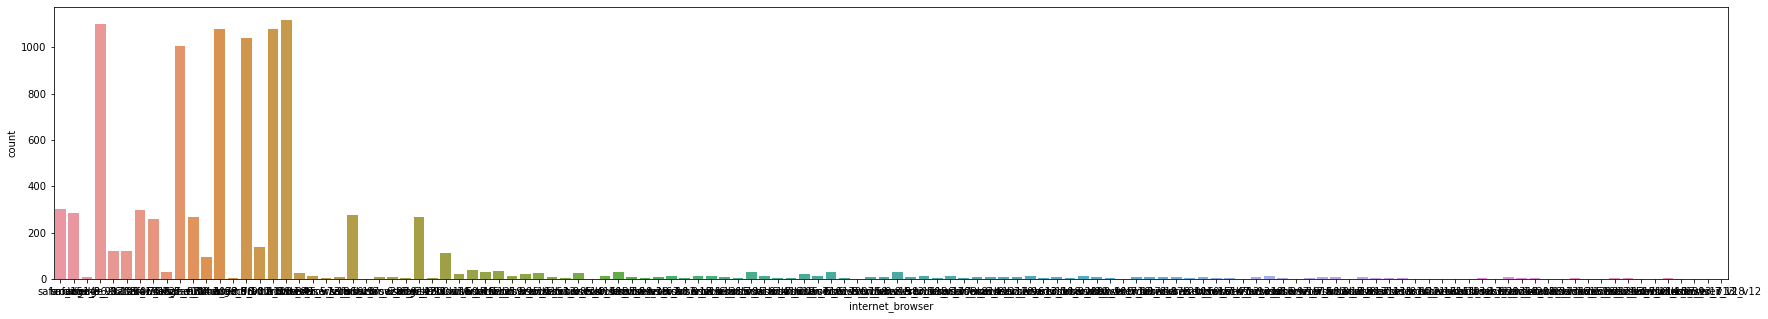

Feature number: user_type


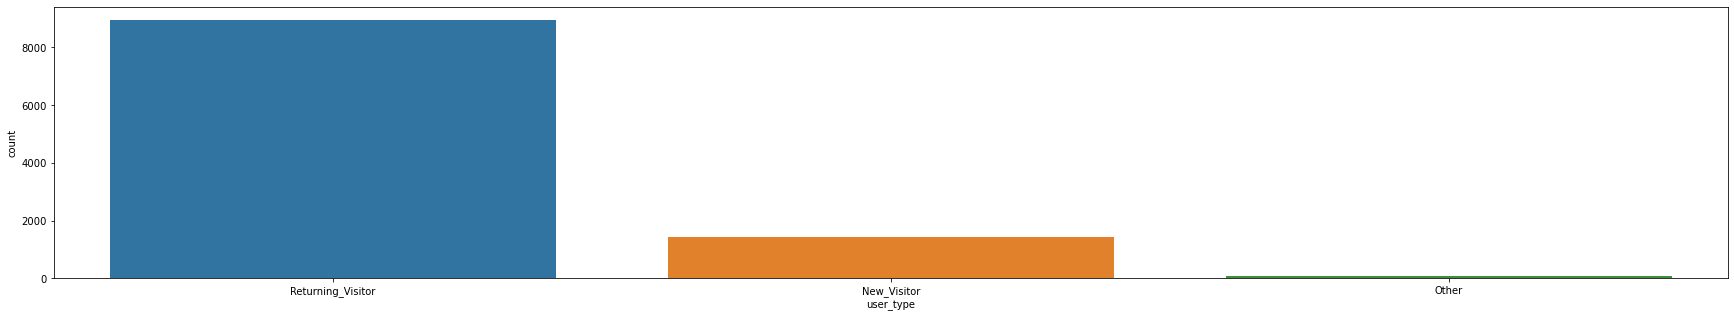

Feature number: Weekend


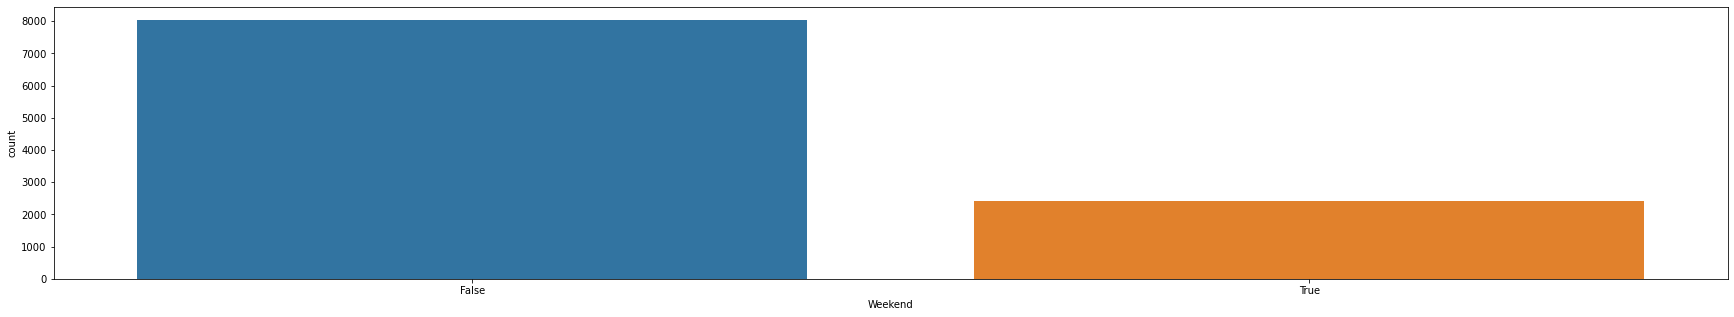

Feature number: A


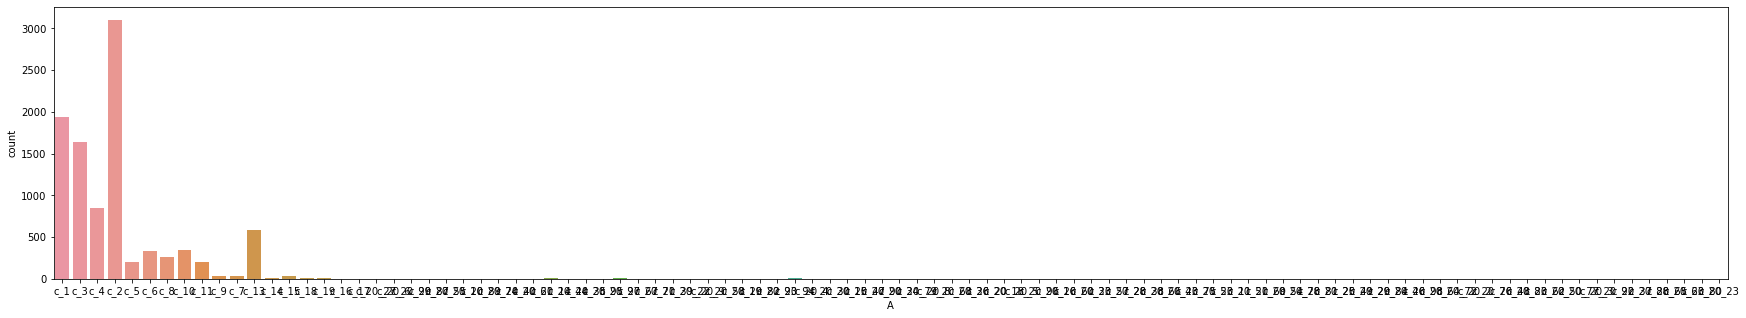

Feature number: C


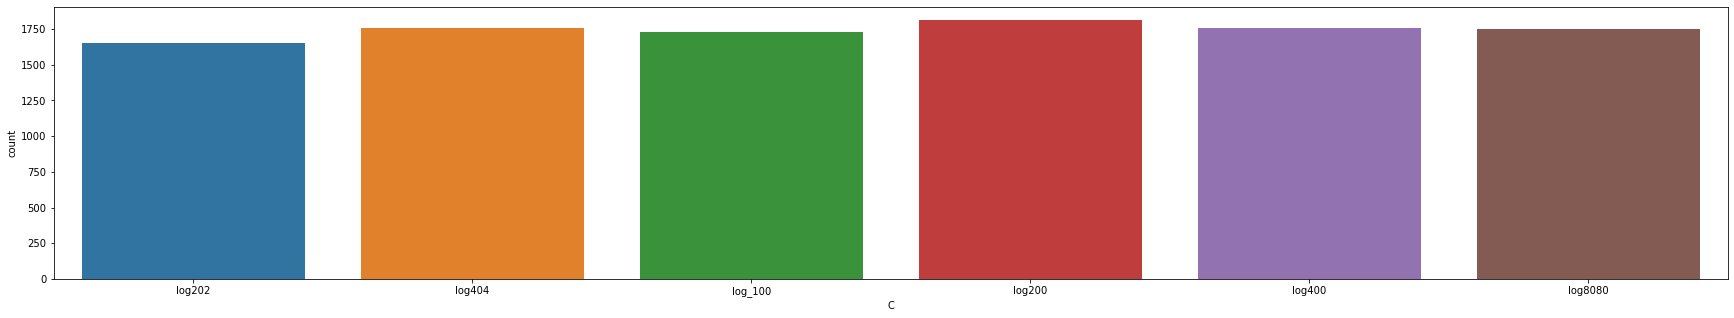

Feature number: device


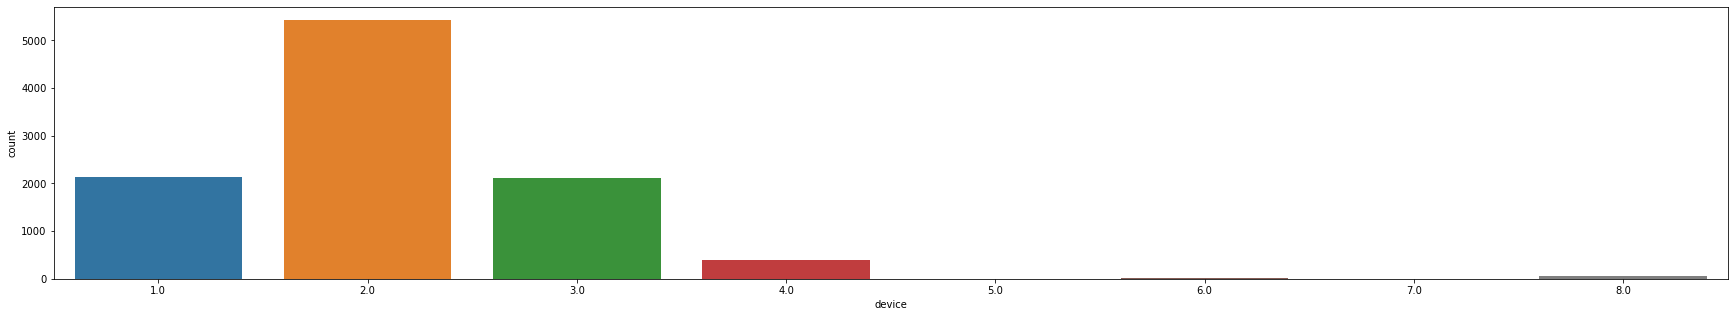

Feature number: Region


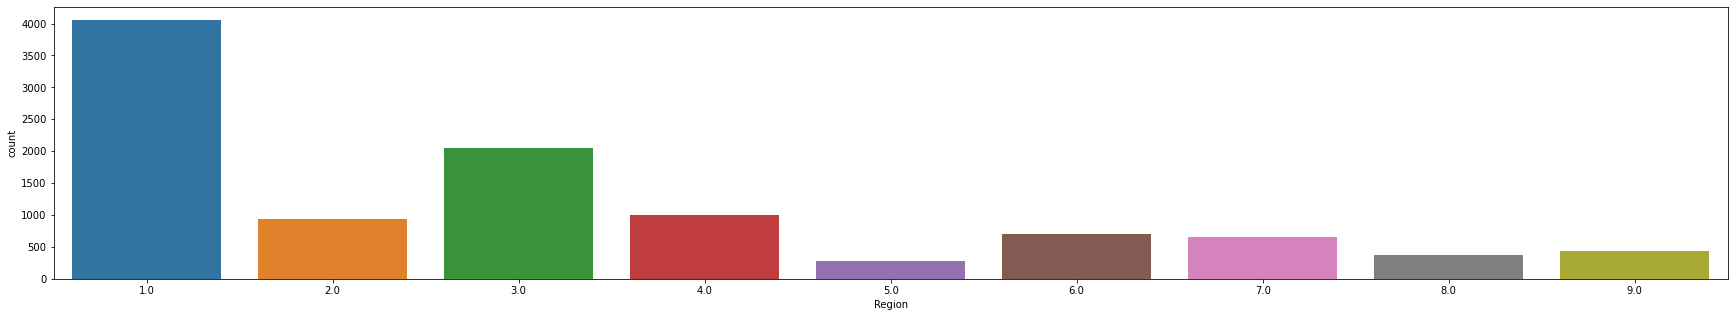

In [12]:
def categorial_dist(df):
    for column in df:                                                 
            print ('Feature number:', column)
            fig, ax =plt.subplots(figsize=(30, 5))                                  
            sns.countplot(df[column])
            plt.show()
categorial_dist(data_category.iloc[:,:-1])


The features info_page_duration and product_page_duration are distrabuted over a large range of values. An exploration of the data revealed that they contain a numeric value with the suffix "minutes", meaning that they are numeric columns and therefore we will make them numeric by deleting the suffix.

## Now let's dive in to some of the features. 



#### Let's find out which device purchases the most

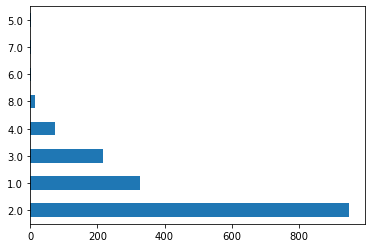

In [13]:
pur_device=data.loc[(data['purchase'] == 1) , 'device']
pur_device.value_counts().plot.barh()
plt.show()


#### The next feature is "internet browser". Which we have to remember has more then a 100 unique values! So let's clean it up-


In [14]:
data = clean_browser(data)
test_data = clean_browser(test_data)
data["internet_browser"].nunique()

4

Now that we have reduced the number of different browsers to 4, we will show how our data is distributed regarding internet browsers - 

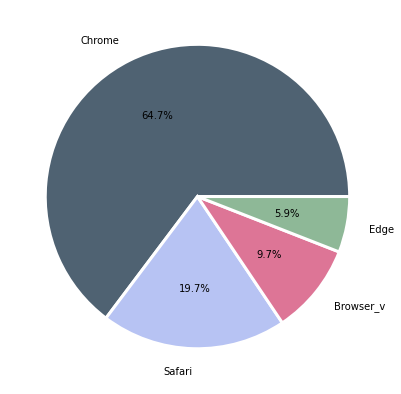

In [15]:
num_of_users = data['internet_browser'].value_counts()
browsers = ['Chrome' , 'Safari' , 'Browser_v' , 'Edge']
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']
plt.rcParams['figure.figsize'] = (17, 7)
plt.pie(num_of_users, labels= browsers, labeldistance=1.15 ,autopct='%1.1f%%', wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' } , colors=colors );
plt.show();


# Pre Processing

#### Before we start, here are some helping functions we will use later on - 

In [16]:
# drop feature from data and returning df without said feature 
def drop_from_data(data1 , feat):    
    data1 = data1.drop(columns=str(feat), axis=1)
    return data1

# remove outleiers according to z-score from col 
def rem_out(data , col):
    df = data[[col]].copy()
    df = df.dropna()
    out_L_index = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)].index 
    rows_no_outl_index = data.iloc[out_L_index, :].index

    row_index = df.drop(rows_no_outl_index).index
    data_clean = data.drop(row_index).copy()

    removed = ((data.shape[0]-data_clean.shape[0])/data.shape[0])*100
    print ("%.2f" %removed , "%" , "removed outliers", "\n")

    return data_clean


# plotting features in a way that let us see outleiers 
def plot_my_ol(data):

    plt.figure(1)
    sns.stripplot(data['PageValues'], palette = 'winter', orient = 'h')
    plt.title('Page Values', fontsize = 20)
    plt.xlabel('PageValues', fontsize = 10)

    plt.figure(2)
    sns.stripplot(data['num_of_admin_pages'], palette = 'summer', orient = 'h')
    plt.title('Number of admin pages', fontsize = 20)
    plt.xlabel('num_of_admin_pages', fontsize = 10)

    plt.figure(3)
    sns.stripplot(data['num_of_product_pages'], palette = 'spring', orient = 'h')
    plt.title('number of product pages', fontsize = 20)
    plt.xlabel('num_of_product_pages', fontsize = 10)

    plt.show()

# removing outleiers above given precentile  

def clean_with_thrash(data , thr):
    thresh = np.nanpercentile(data['PageValues'],[float(thr)])
    print(thresh)
    thresh2 = np.nanpercentile(data['num_of_admin_pages'],[float(thr)])
    print(thresh2)
    thresh3 = np.nanpercentile(data['num_of_product_pages'],[float(thr)])
    print(thresh3)

    data = data[data['PageValues'] <= float(thresh)]
    data = data[data['num_of_admin_pages'] <= float(thresh2)]
    data = data[data['num_of_product_pages'] <= float(thresh3)]

    return data


def fill_na_data(data_c , data_category , data_numeric , test = False):

        if(True):

            data_numeric1 = drop_from_data(data_numeric , 'D')

        # categorical columns
        data.fillna(data_category.select_dtypes(include='object').mode().iloc[0], inplace=True)
        data_c[['Region','internet_browser','device']] = data_c[['Region','internet_browser','device']].fillna(data[['Region','internet_browser','device']].mode().iloc[0])

        if(True):

            data_numeric1 = drop_from_data(data_numeric , 'D')
        # numeric columns
            colist = list(data_numeric1.columns)
            data_c[colist] = data_c[colist].fillna(data[colist].median())
        else:
             # numeric columns
            colist = list(data_numeric.columns)
             
            data_c[colist] = data_c[colist].fillna(data[colist].median())
            


        

First, as we can remember from both our heat map and the null count, total_duration contains a large amount of null values (over 40%) *and* has an 0.88 corrolation with num_of_product_pages. Because of those two reasons, we have decided to delete the feature total_duration. 

In [17]:
data = drop_from_data(data , 'total_duration')
test_data = drop_from_data(test_data , 'total_duration')


Secondly, due to the extreamly high (0.91) corrolation between BounceRates and Exitrates, we decided to delete the feature BounceRates as well.
Also the features product_page_duration and num_of_product_pages, had a high correlation and we decided to delete product_page_duration.

In [18]:
data = drop_from_data(data , 'BounceRates')
test_data = drop_from_data(test_data , 'BounceRates')

data = drop_from_data(data , 'product_page_duration')
test_data = drop_from_data(test_data , 'product_page_duration')

In addition, in preparation for creating new features, we will convert Weekend to be a binary variable that receives 0/1 instead of TRUE/FALSE

In [19]:
data['Weekend'] = data['Weekend'].fillna(0) #have to fill null values before converting , most days arnt weekend. 
data['Weekend'] = data['Weekend'].astype(int)

#### Now before we start dealing with outliers, we noticed that ExitRates distribution looks fairly unique, so we decided to preform Box-Cox transformation on it.

<AxesSubplot:ylabel='Density'>

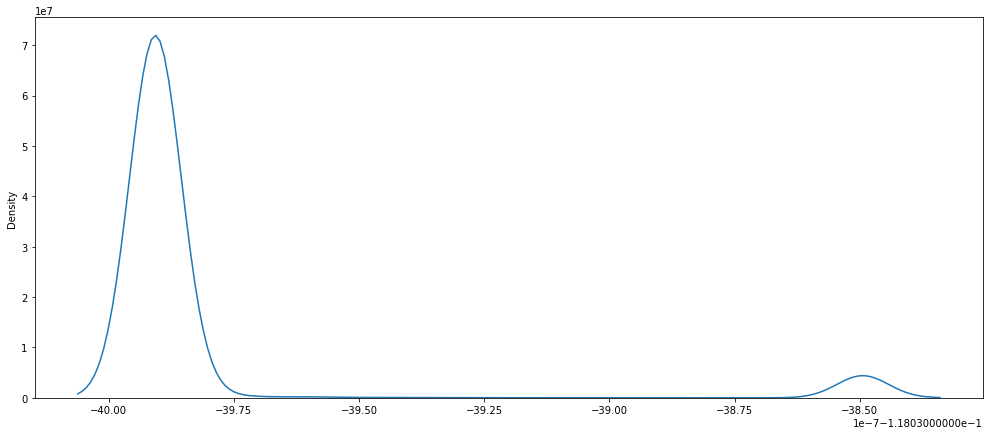

In [20]:
#boxcox function works just with positive values, let's check how many zeros we have
data.loc[(data['ExitRates'] == 0), 'ExitRates'].count()
test_data.loc[(test_data['ExitRates'] == 0), 'ExitRates'].count()


#replace 0 with 0.1
data['ExitRates']=data.ExitRates.mask(data.ExitRates == 0,0.001)
test_data['ExitRates']=test_data.ExitRates.mask(data.ExitRates == 0,0.001)


#perform Box-Cox transformation on original data
transformed_data, best_lambda = boxcox(data['ExitRates'])

#plot the distribution of the transformed data values
sns.distplot(transformed_data, hist=False, kde=True) 



After applaying Box-cox, it seem like there are 2 gaussian distributions within this feature. Therefore we will not use the box plot in order to remove outliers from this feater. 

# Removing Outliers

It'll be easier to start with 'B', as it seem to be distributed normally. Hence, we will use Box-plot in order to identifie and remove Outliers.

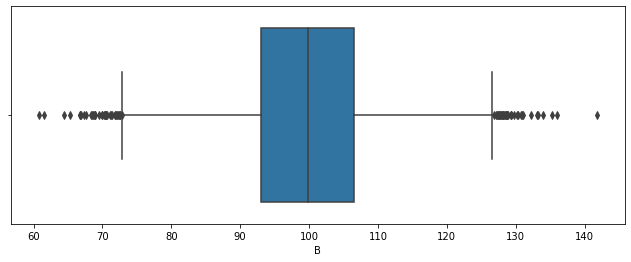

In [21]:
plt.figure(figsize=(11,4))
sns.boxplot(data['B'])
plt.show()

Here we have used the rem_out function in order to find and remove outliers using zscore - 

In [22]:
data = rem_out(data , 'B')

0.27 % removed outliers 



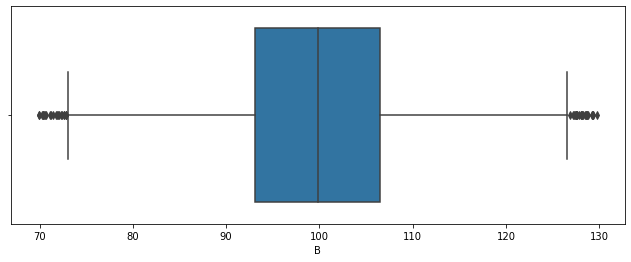

In [23]:
plt.figure(figsize=(11,4))
sns.boxplot(data['B'])
plt.show()

Now let's move to page_values and num_of_admin_page and num_of_product_pages - 

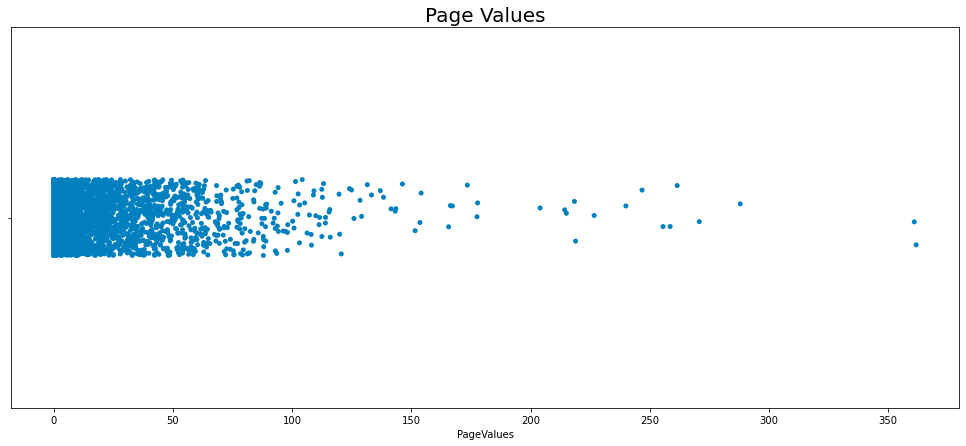

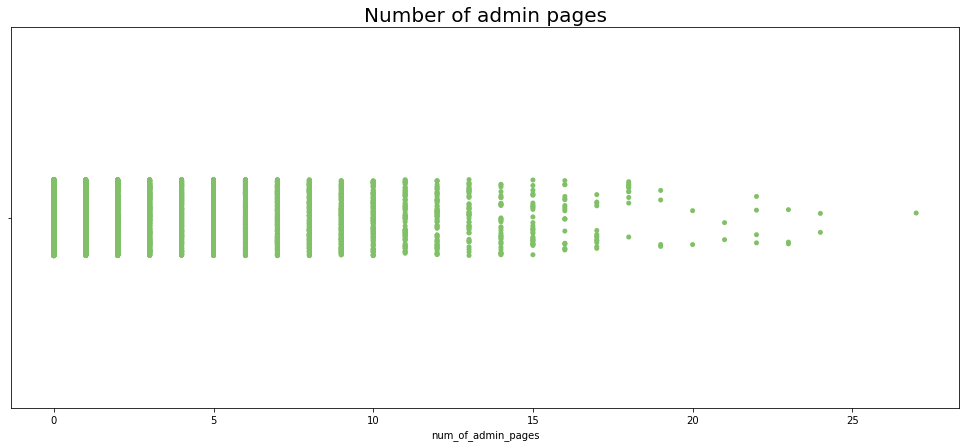

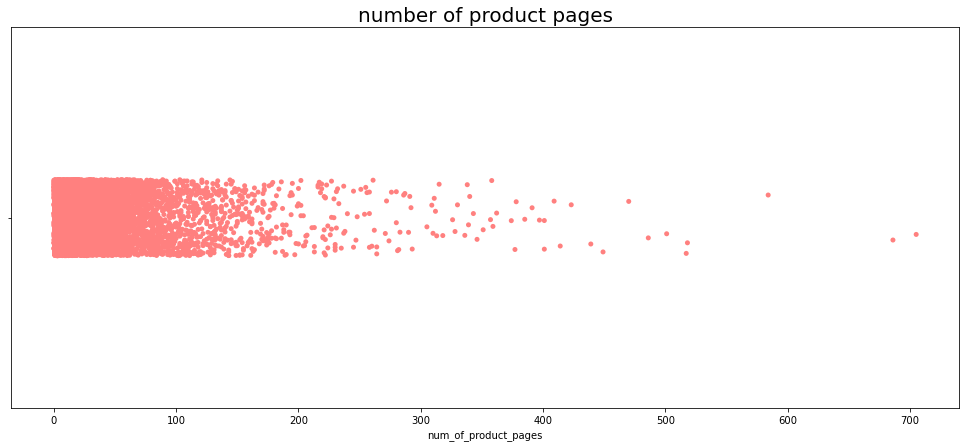

In [24]:

plot_my_ol(data)

After a number of tries, we've decided on a threshold value for all of those features - 99.993. This value gave us the highest test AUC score. 

[361.1724966]
[24.93171]
[691.63483]


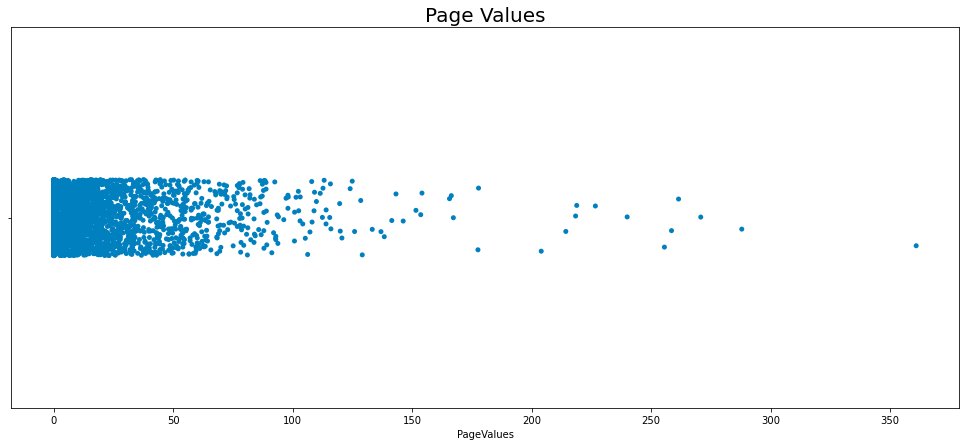

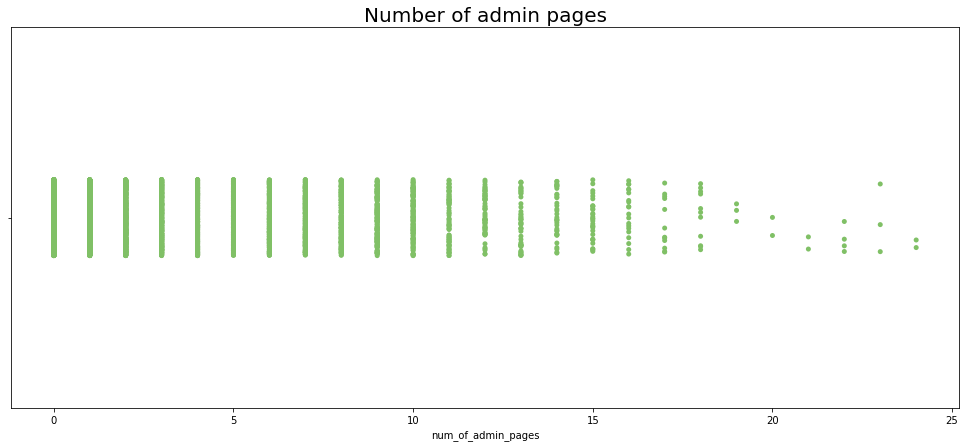

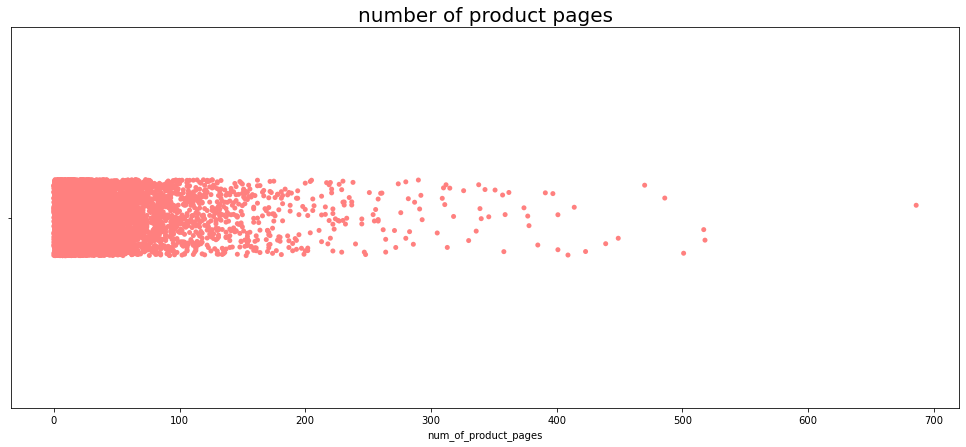

In [25]:

data = clean_with_thrash(data , 99.993)
plot_my_ol(data)

In [26]:
data.isnull().sum()


num_of_admin_pages         0
admin_page_duration      358
num_of_info_pages        597
info_page_duration       267
num_of_product_pages       0
ExitRates                  2
PageValues                 0
closeness_to_holiday     425
Month                      3
device                   279
internet_browser         504
Region                     2
user_type                  2
Weekend                    0
A                        614
B                          1
C                          4
D                       9372
purchase                   0
dtype: int64

### Fill null values <br>
In the numerical features, we will replace the null values with the median of the column. We chose median (and not mean) because not all columns are distributed normally, so median will be a better value (less affected by extreme values). <br>
In the categorical features, we will replace the null values with the train set most frequent value (of said feature). We chose the most frequent value because we wanted to avoid creating too many new features.
We have considered D as a spacial case, from one hand it contains a relativly large amount of missing values, and from the other, it has fairly high corrolation with our labels! That's why we have decided to use KNNimputer on that column.

In [27]:

data_numeric, data_category=split_data(data)
fill_na_data(data,data_category,data_numeric)
print(data.isnull().sum())

# now for the test data
fill_na_data(test_data,data_category,data_numeric , test=True)
print(test_data.isnull().sum())


num_of_admin_pages         0
admin_page_duration        0
num_of_info_pages          0
info_page_duration         0
num_of_product_pages       0
ExitRates                  0
PageValues                 0
closeness_to_holiday       0
Month                      0
device                     0
internet_browser           0
Region                     0
user_type                  0
Weekend                    0
A                          0
B                          0
C                          0
D                       9372
purchase                   0
dtype: int64
num_of_admin_pages         0
admin_page_duration        0
num_of_info_pages          0
info_page_duration         0
num_of_product_pages       0
ExitRates                  0
PageValues                 0
closeness_to_holiday       0
Month                      3
device                     0
internet_browser           0
Region                     0
user_type                  2
Weekend                    0
A                        121
B

#### Reducing the number of unique values for the columns A and device

In [28]:
# checking num of uniqe values for A and device 

uniq_A = data['A'].nunique()
print(uniq_A)
uniq_dev = data['device'].nunique()
#print(uniq_dev)

# cheking amount per value 

num_of_vals_dev = data['device'].value_counts()
print(num_of_vals_dev)
num_of_vals_A = data['A'].value_counts()
num_of_vals_A_test = test_data['A'].value_counts()
print(num_of_vals_A)

# uniting all values that repit less them 200 times into 'other'

def get_redundent(data ,test , col , num_of_vals , num_of_vals_A_test = None):
    mydata = data.copy()
    mydata['device'] = mydata.device.astype('string')

    mytest = test.copy()
    mytest['device'] = mytest.device.astype('string')
    item_lst = []

    for item in num_of_vals.items():
        if((item[1] < 200)):
            item_lst.append(item[0])
            mydata.loc[mydata[col].str.contains(str(item[0]) , na = False), str(col)] = 'other'
            mytest.loc[mytest[col].str.contains(str(item[0]) , na = False), str(col)] = 'other'

    if(col == 'A'):
        for item in num_of_vals_A_test.items():
            if(item[0] not in num_of_vals):
                mytest.loc[mytest[col].str.contains(str(item[0]) , na = False), str(col)] = 'other'        

    




    mydata['device'] = mydata.device.astype('category')
    mytest['device'] = mytest.device.astype('category')

    return mydata , mytest


data , test_data = get_redundent(data ,test_data , 'A', num_of_vals_A , num_of_vals_A_test)

data , test_data = get_redundent(data ,test_data, 'device' , num_of_vals_dev )


print('We have reduced the number of uniqe values in {} to {}'.format('device' , str(data['device'].nunique())))
print('We have reduced the number of uniqe values in {} to {}'.format('A' , str(data['A'].nunique())))



94
2.0    5188
3.0    1934
1.0    1926
4.0     343
8.0      56
6.0      16
5.0       4
7.0       3
Name: device, dtype: int64
c_2        3430
c_1        1758
c_3        1492
c_4         766
c_13        539
           ... 
c_20_51       1
c_20_54       1
c_20_34       1
c_20_25       1
c_20_96       1
Name: A, Length: 94, dtype: int64
We have reduced the number of uniqe values in device to 5
We have reduced the number of uniqe values in A to 9


### Scailing- Data transformation

As we have seen in the exploration phase, the features are on different scales. Here we will normalize them to be on the same scale. Scaling is an important process for dimension reduction methods, and for model preformance. In order for the models to predict well, they have to have all the values of the features in the same scale.

In [29]:

data_numeric, data_category=split_data(data)
# min max scaling

data[data_numeric.columns]=(data[data_numeric.columns]-data[data_numeric.columns].min())/(data[data_numeric.columns].max()-data[data_numeric.columns].min())
test_data[data_numeric.columns]=(test_data[data_numeric.columns]-test_data[data_numeric.columns].min())/(test_data[data_numeric.columns].max()-test_data[data_numeric.columns].min())
data.head()


,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,ExitRates,PageValues,closeness_to_holiday,Month,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase
0,0.0,0.0,0.0,0.0,0.001458,1.000000,0.0,0.0,Feb,1.0,safari,1.0,Returning_Visitor,0.0,c_1,0.818667,log202,NaN,0
1,0.0,0.0,0.0,0.0,0.001458,1.000000,0.0,0.0,Feb,4.0,safari,9.0,Returning_Visitor,0.0,c_3,0.726322,log404,NaN,0
3,0.0,0.0,0.0,0.0,0.027697,0.122036,0.0,0.0,Feb,2.0,chrome,1.0,Returning_Visitor,0.0,c_3,0.398344,log_100,NaN,0
4,0.0,0.0,0.0,0.0,0.001458,1.000000,0.0,0.4,Feb,2.0,edge,3.0,Returning_Visitor,0.0,c_3,0.495321,log202,NaN,0
5,0.0,0.0,0.0,0.0,0.002915,0.499561,0.0,0.8,Feb,2.0,chrome,2.0,Returning_Visitor,0.0,c_3,0.581727,log200,NaN,0


### Convert categorical columns to dummies variables

In [30]:
data_numeric, data_category=split_data(data)
test_data_numeric, test_data_category=split_data(test_data)
print(data_category[:].nunique())


data = pd.get_dummies(data,columns=['Month','internet_browser','user_type','A','C','device','Region'],drop_first=True)
test_data = pd.get_dummies(test_data,columns=['Month','internet_browser','user_type','A','C','device','Region'],drop_first=True)


Month               10
internet_browser     4
user_type            3
A                    9
C                    6
device               5
Region               9
purchase             2
dtype: int64


#### Data engineering
We have decided to create the following features - Weekend * closeness_to_holiday, and total_num_of_pages

In [31]:

def data_eng(data):
    data['Weekend'] = data['Weekend'].astype(int)
    data["Weekend*closeness_to_holiday"] = data['Weekend'] * data["closeness_to_holiday"]
    data["total_num_of_pages"] = data['num_of_admin_pages'] + data["num_of_info_pages"]+ data["num_of_product_pages"]
data_eng(data)
data_eng(test_data)
data.head()

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,ExitRates,PageValues,closeness_to_holiday,Weekend,B,...,Region_2.0,Region_3.0,Region_4.0,Region_5.0,Region_6.0,Region_7.0,Region_8.0,Region_9.0,Weekend*closeness_to_holiday,total_num_of_pages
0,0.0,0.0,0.0,0.0,0.001458,1.000000,0.0,0.0,0,0.818667,...,0,0,0,0,0,0,0,0,0.0,0.001458
1,0.0,0.0,0.0,0.0,0.001458,1.000000,0.0,0.0,0,0.726322,...,0,0,0,0,0,0,0,1,0.0,0.001458
3,0.0,0.0,0.0,0.0,0.027697,0.122036,0.0,0.0,0,0.398344,...,0,0,0,0,0,0,0,0,0.0,0.027697
4,0.0,0.0,0.0,0.0,0.001458,1.000000,0.0,0.4,0,0.495321,...,0,1,0,0,0,0,0,0,0.0,0.001458
5,0.0,0.0,0.0,0.0,0.002915,0.499561,0.0,0.8,0,0.581727,...,1,0,0,0,0,0,0,0,0.0,0.002915


#### Using KNN imputer on the column "D"

In [32]:
### create an imputer for train data
imputer = KNNImputer(n_neighbors=10 , weights = 'distance')
print(data['D'].isnull().sum())
print(test_data['D'].isnull().sum())


### create a copy of the data witout labels so we dont use it to impute missing values of D 
X_impu=data.drop(columns="purchase")
y_impu=data["purchase"]

### fit and tranform new data to fill nan values for D 

impute_data = pd.DataFrame(imputer.fit_transform(X_impu, y=y_impu), columns=X_impu.columns)

## replace D values of old data with imputed ones 


### use train data without labels to fit new imputer 
test_imputer = KNNImputer(n_neighbors=10 , weights = 'distance')
test_imputer =test_imputer.fit(X_impu)

### impute missing test data 

impute_data_test = pd.DataFrame(test_imputer.transform(test_data), columns=test_data.columns)

impute_data.head()



9372
1832


,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,ExitRates,PageValues,closeness_to_holiday,Weekend,B,...,Region_2.0,Region_3.0,Region_4.0,Region_5.0,Region_6.0,Region_7.0,Region_8.0,Region_9.0,Weekend*closeness_to_holiday,total_num_of_pages
0,0.0,0.0,0.0,0.0,0.001458,1.000000,0.0,0.0,0.0,0.818667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001458
1,0.0,0.0,0.0,0.0,0.001458,1.000000,0.0,0.0,0.0,0.726322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.001458
2,0.0,0.0,0.0,0.0,0.027697,0.122036,0.0,0.0,0.0,0.398344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027697
3,0.0,0.0,0.0,0.0,0.001458,1.000000,0.0,0.4,0.0,0.495321,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001458
4,0.0,0.0,0.0,0.0,0.002915,0.499561,0.0,0.8,0.0,0.581727,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002915


In [33]:
print(impute_data['D'].isnull().sum())

0


# Dimensionality Reduction

A large number of dimensions may create a problem because first, curse of dimensionality- too many dimensions may reduce the density of observations and lead to high variance and overfitting. Second, the more features there are, the longer the calculation time will be.

### PCA

We need 34 components to explain 95% of variance


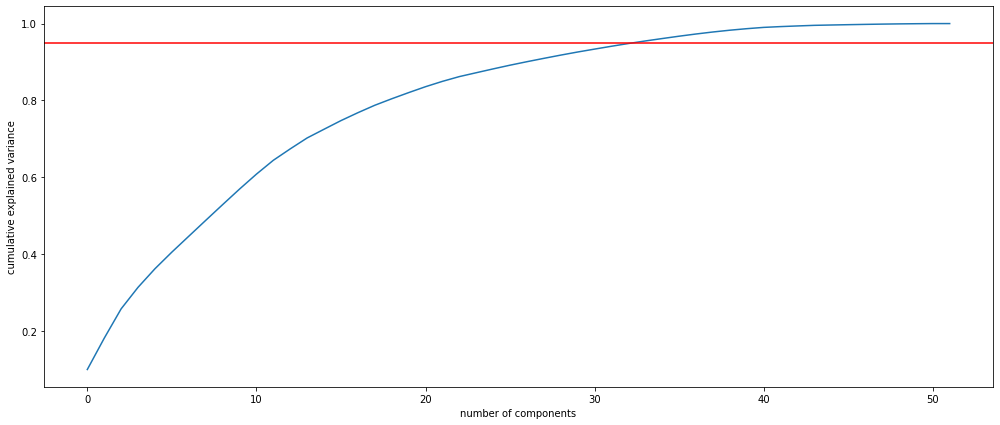

In [34]:
data_num_temp ,data_cat_temp = split_data(impute_data.copy())


pca = PCA().fit(data_num_temp)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('comulative explained variance (%)')
plt.axhline(0.95, c='r')
plt.ylabel('cumulative explained variance');

print('We need ' + str(len(PCA(0.95).fit(data_num_temp).components_)) + ' components to explain 95% of variance')

#### We've decided not use this method becuase we use primarly tree based models.

# Modeling


#### spliting data into train & Validation

In [35]:
# splitting the data to test and validation 
X = impute_data
y = y_impu
X_train, X_Validation, y_train, y_Validation = train_test_split(X, y, test_size=0.25,random_state = 1,shuffle = True) 

## Simple Models
We used Grid Search cross validation, in order to detemin what are the best hyperparameters best on the ROC AUC score.


## Logistic Regression




In [36]:
lg_param = {'penalty':['l1', 'l2'],
                 'C': [0.001, 0.01, 0.1],
                 'max_iter': [100, 150, 350, 500],
                 'solver': ['liblinear', 'lbfgs',  'saga'], 
                 } 
# The defualt parameters:
# dual=False, dual or primal formulation. Dual=False when n_samples > n_features
# tol=0.0001, stopping critiria
# fit_intercept=True,Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
# class_weight=None, all classes are supposed to have weight one
# verbose=0, For the liblinear and lbfgs solvers set verbose to any positive number for verbosity
# warm_start=False, When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. 
# n_jobs=None, #Number of CPU cores used when parallelizing over classes
# l1_ratio=None #The Elastic-Net mixing parameter,default value                 

clf_lg=GridSearchCV(LogisticRegression() , lg_param , scoring='roc_auc',cv=5 , return_train_score=False)
clf_lg.fit(X_train, y_train) 


fpr, tpr, thresholds = roc_curve(y_Validation, clf_lg.predict_proba(X_Validation)[:,1])
val_auc = auc(fpr, tpr)


print ("validation AUC: {}".format(val_auc))
print ( 'best parametes: {}'.format(clf_lg.best_params_))

validation AUC: 0.8862666048499265
best parametes: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}


In [37]:
LR_clf = LogisticRegression(**clf_lg.best_params_, random_state = 0)


# KNN

In [38]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
k_range = list(range(1, 50 , 5 ))
param_grid = { 'n_neighbors' : k_range ,'weights': ['uniform', 'distance'],
                  'p' : [1,2],
                  'metric': ['minkowski','euclidean', 'manhattan'] }
  
# The defualt parameters:
# algorithm - {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’ , Algorithm used to compute the nearest neighbors:
# leaf_sizeint, default=30 Leaf size passed to BallTree or KDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree
# n_jobsint, default=None , The number of parallel jobs to run for neighbors search

grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', return_train_score=False)
grid_search_knn.fit(X_train, y_train)

best_params_knn = grid_search_knn.best_params_
best_score = grid_search_knn.best_score_
print('Best Parameters: {}'.format(best_params_knn))

fpr, tpr, thresholds = roc_curve(y_Validation, grid_search_knn.predict_proba(X_Validation)[:,1])
val_auc = auc(fpr, tpr)
print ("validation AUC: {}".format(val_auc))


###
        

# clf_lg=GridSearchCV(LogisticRegression() , lg_param , scoring='roc_auc',cv=5 , return_train_score=False)
# clf_lg.fit(X_train, y_train) 


# fpr, tpr, thresholds = roc_curve(y_Validation, clf_lg.predict_proba(X_Validation)[:,1])
# val_auc = auc(fpr, tpr)


# print ("validation AUC: {}".format(val_auc))
# print ( 'best parametes: {}'.format(clf_lg.best_params_))


Best Parameters: {'metric': 'minkowski', 'n_neighbors': 46, 'p': 1, 'weights': 'uniform'}
validation AUC: 0.7223716126778071


In [39]:
knn_final =  KNeighborsClassifier( **best_params_knn )

# Complex Models 

## Decision Tree

In [40]:
clf_dt = DecisionTreeClassifier(random_state = 1 )
clf_dt = clf_dt.fit(X_train , y_train)

Choosing the optimal alpha using the cost_complexity_pruning_path function. Alpha parameter detemines as it increases more of the tree is pruned which increses the total impurity if it's leaves.

In [41]:
path = clf_dt.cost_complexity_pruning_path(X_train , y_train)
ccp_alphas = path.ccp_alphas # different values for alpha
ccp_alphas = ccp_alphas[:-1]

clf_dts_lst = []

for alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=1 , ccp_alpha=alpha)
    clf_dt.fit(X_train,y_train)
    clf_dts_lst.append(clf_dt)


Best alpha value is 0.000635300976847223


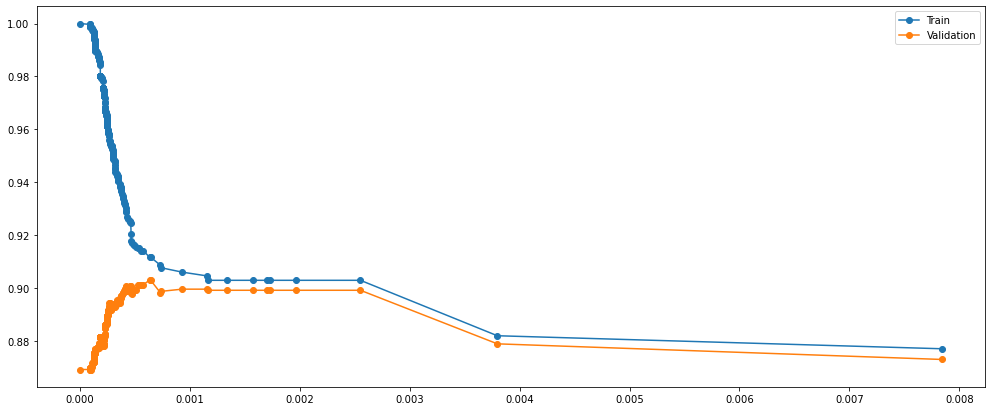

In [42]:
train_score = [clf_dt.score(X_train,y_train) for clf_dt in clf_dts_lst]
validation_score = [clf_dt.score(X_Validation,y_Validation) for clf_dt in clf_dts_lst]



fig, ax = plt.subplots()
ax.plot(ccp_alphas, train_score , marker = 'o' , label = 'Train')
ax.plot(ccp_alphas, validation_score , marker = 'o' , label = 'Validation')
ax.legend()


arg_loc = np.argmax(validation_score)
alpha_opt = ccp_alphas[arg_loc]

print('Best alpha value is {}'.format(alpha_opt))


Choosing the rest of the hyparameters and using our chosen alpha.

In [43]:
parameters = {
    'splitter':['best', 'random'],
    'criterion':['gini', 'entropy' , 'log_loss' ],
    'max_depth':[None, 2,4, 5,7],   
    'min_samples_split':[2, 3, 5, 8]
}

# The defualt parameters:
# min_samples_leafint or float, default=1 , The minimum number of samples required to be at a leaf node
# min_weight_fraction_leaffloat, default=0.0 . The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
# max_featuresint, float or {“auto”, “sqrt”, “log2”}, default=None , The number of features to consider when looking for the best split.
# max_leaf_nodesint, default=None , Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited # # number of leaf nodes.
# class_weightdict, list of dict or “balanced”, default=None

clf_hp_dt = DecisionTreeClassifier(random_state=1 , ccp_alpha=alpha_opt)
gs_clf = GridSearchCV(clf_hp_dt, parameters, scoring='roc_auc',n_jobs=2)
gs_clf.fit(X_train, y_train)


GridSearchCV(estimator=DecisionTreeClassifier(ccp_alpha=0.000635300976847223,
                                              random_state=1),
             n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 2, 4, 5, 7],
                         'min_samples_split': [2, 3, 5, 8],
                         'splitter': ['best', 'random']},
             scoring='roc_auc')

In [44]:
best_params = gs_clf.best_params_
best_score = gs_clf.best_score_

print('Best Parameters: {}'.format(best_params))
print('Train AUC score for best params: {}'.format(best_score))

fpr, tpr, thresholds = roc_curve(y_Validation, gs_clf.predict_proba(X_Validation)[:,1])
val_auc = auc(fpr, tpr)
print ("validation AUC: {}".format(val_auc))

Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'splitter': 'best'}
Train AUC score for best params: 0.9189657712249616
validation AUC: 0.9297130225026373


In [45]:

clf_alpha_hp = DecisionTreeClassifier(random_state=1, **best_params , ccp_alpha=alpha_opt)
clf_alpha_hp.fit(X_train, y_train)

fpr, tpr, thresholds = roc_curve(y_Validation, clf_alpha_hp.predict_proba(X_Validation)[:,1])
print("AUC: ",auc(fpr, tpr))

AUC:  0.9297130225026373


For the next step we would like to reduce the number of features in the model using feature_importances - 

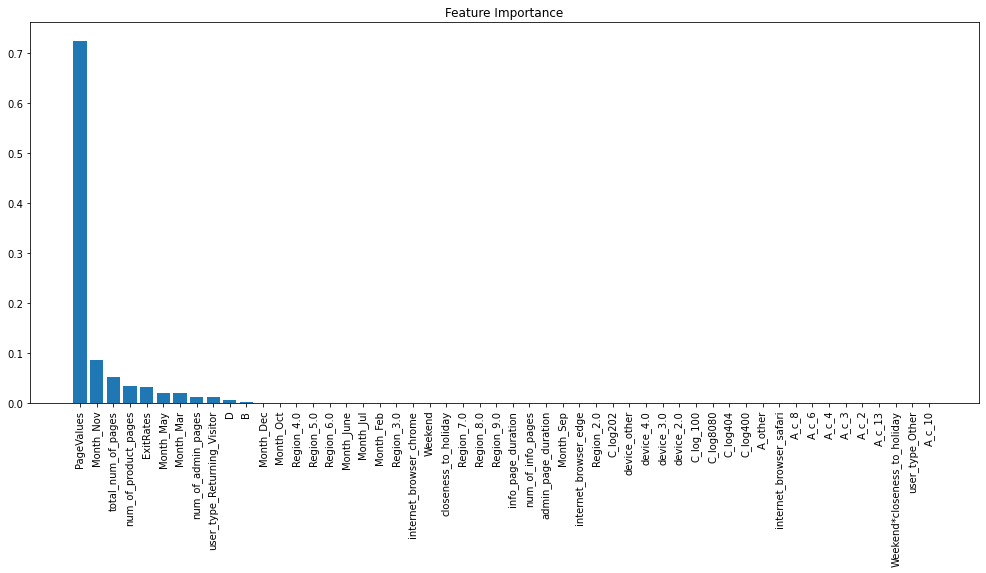

In [46]:
#model
model = clf_alpha_hp
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = X_train.columns[indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

We can see that our model only uses 11 of our features. 
Before plotting the tree, we will remove the unneccery features.

In [47]:
most_important = np.sort(importances)[::-1]
most_important
names[0:11]

Index(['PageValues', 'Month_Nov', 'total_num_of_pages', 'num_of_product_pages',
       'ExitRates', 'Month_May', 'Month_Mar', 'num_of_admin_pages',
       'user_type_Returning_Visitor', 'D', 'B'],
      dtype='object')

Now we will plot the tree and check our test AUC - 

AUC:  0.9261498249645561


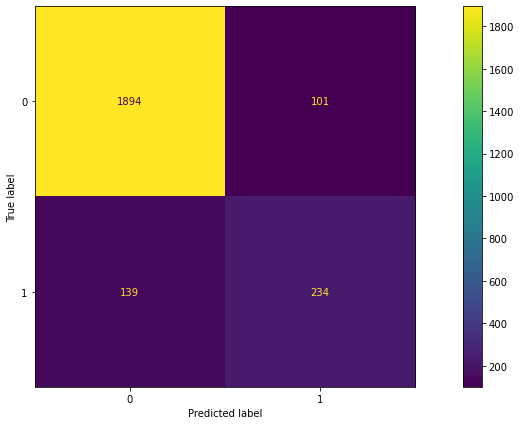

In [48]:
X_train_imp ,y_train_imp , X_Validation_imp ,y_Validation_imp = X_train[names[0:13]] ,y_train , X_Validation[names[0:13]] ,y_Validation

best_params = best_params
clf_DT = DecisionTreeClassifier(random_state=1, **best_params)
clf_DT.fit(X_train_imp, y_train_imp)
fpr, tpr, thresholds = roc_curve(y_Validation_imp, clf_DT.predict_proba(X_Validation_imp)[:,1])
print("AUC: ",auc(fpr, tpr))

plot_confusion_matrix(clf_DT , X_Validation_imp , y_Validation)


[Text(0.4244791666666667, 0.9166666666666666, 'PageValues <= 0.0\nentropy = 0.621\nsamples = 7102\nvalue = [6005, 1097]'),
 Text(0.16666666666666666, 0.75, 'Month_Nov <= 0.5\nentropy = 0.238\nsamples = 5557\nvalue = [5340, 217]'),
 Text(0.08333333333333333, 0.5833333333333334, 'Month_May <= 0.5\nentropy = 0.119\nsamples = 4230\nvalue = [4162, 68]'),
 Text(0.0625, 0.4166666666666667, 'Month_Mar <= 0.5\nentropy = 0.17\nsamples = 2701\nvalue = [2633, 68]'),
 Text(0.041666666666666664, 0.25, 'num_of_admin_pages <= 0.021\nentropy = 0.235\nsamples = 1769\nvalue = [1701, 68]'),
 Text(0.020833333333333332, 0.08333333333333333, 'entropy = 0.086\nsamples = 830\nvalue = [821, 9]'),
 Text(0.0625, 0.08333333333333333, 'entropy = 0.339\nsamples = 939\nvalue = [880, 59]'),
 Text(0.08333333333333333, 0.25, 'entropy = 0.0\nsamples = 932\nvalue = [932, 0]'),
 Text(0.10416666666666667, 0.4166666666666667, 'entropy = 0.0\nsamples = 1529\nvalue = [1529, 0]'),
 Text(0.25, 0.5833333333333334, 'num_of_product

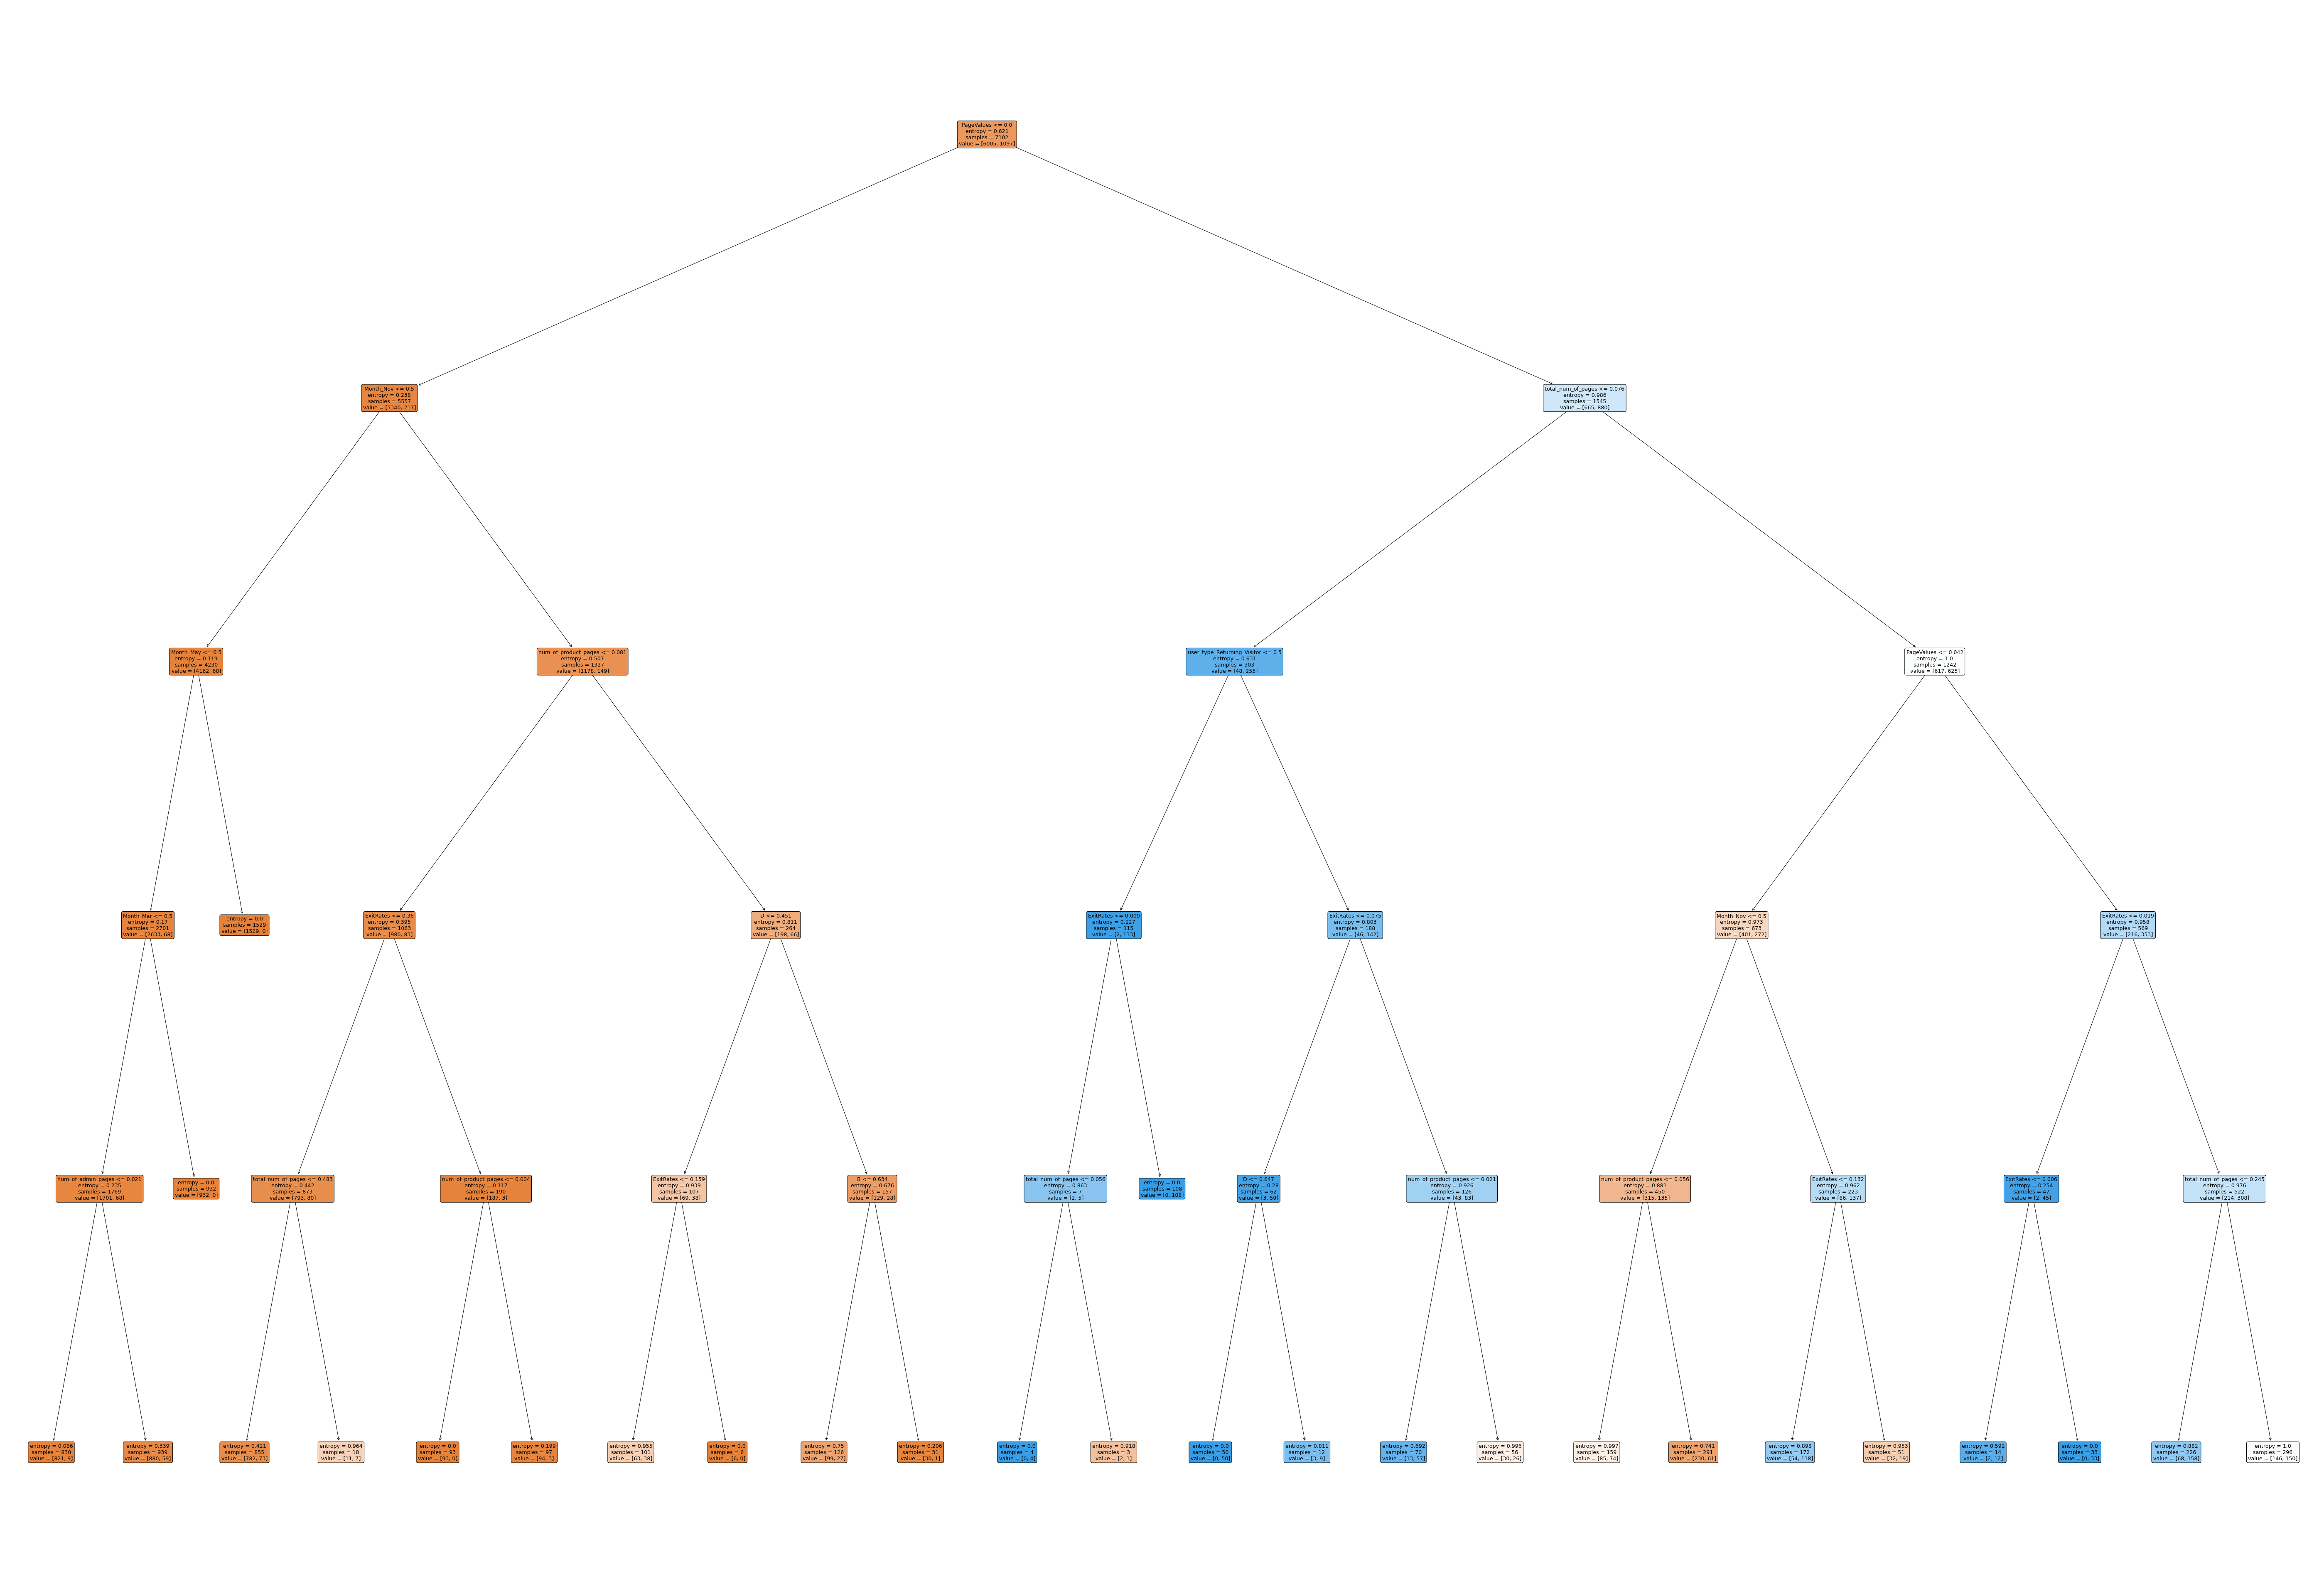

In [49]:

fig = plt.figure(figsize= (100,70))
plot_tree(clf_DT , filled=True , rounded=True , feature_names= X_train_imp.columns)

In [50]:
fig.savefig("decistion_tree.png")


### AdaBoost

In [51]:
#finding the best parameters for the model
adaboost_params = {'n_estimators':[40,45,50,55,70 ],  'learning_rate': [0.7,0.5, 0.01, 1] ,   'base_estimator' :[DecisionTreeClassifier(
                max_depth=2)]}


#clf_ada = AdaBoostClassifier()
#params_avail = clf_ada.get_params().keys()

# run grid search
#grid_ada = GridSearchCV(clf_ada, adaboost_params, cv=5, scoring='roc_auc')
#grid_ada.fit(X,y)


#best_params_ada = grid_ada.best_params_

#print ('AdaBoostClassifier chosen parameters (recieved best AUC): {}'.format(grid_ada.best_params_))
#print ("AdaBoostClassifier AUC score with the chosen parameters: ", grid_ada.best_score_)




In [52]:
#ada_final =  AdaBoostClassifier( **best_params_ada )
#ada_final.fit(X_train,y_train)

#fpr, tpr, thresholds = roc_curve(y_Validation, ada_final.predict_proba(X_Validation)[:,1])
#print(auc(fpr, tpr))

In [53]:
#ada_final =  AdaBoostClassifier( **best_params_ada )

# Random Forest

In [54]:
random_forest_params = {'n_estimators': [ 200 , 250] , 
 'criterion' : ['gini', 'entropy'],
 'max_features': ['log2', 'sqrt' , None],
 'min_samples_split': [5 , 10],
 'min_samples_leaf': [5,10]
 }

### parameters we left as defult ### 

# The defualt parameters: *max_depth= best_parameters['max_depth'],#The maximum depth of the tree.
# *min_weight_fraction_leaf= 0.0, The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. 
# max_leaf_nodes= None, Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
# min_impurity_decrease= 0.0, A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
# min_impurity_split= None, Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.
# bootstrap= True, Whether bootstrap samples are used when building trees. 
# oob_score= False, Whether to use out-of-bag samples to estimate the generalization accuracy
# n_jobs= None, The number of jobs to run in parallel
# random_state= 0,  seed
# verbose= 0, Controls the verbosity when fitting and predicting.
# warm_start= False, When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest                         
# class_weight= None, all classes are supposed to have weight one


clf_rf= RandomForestClassifier()

# run grid search
grid_rf = GridSearchCV(clf_rf, random_forest_params, cv=5, scoring='roc_auc' , n_jobs=4)
grid_rf.fit(X,y)


best_params_rf = grid_rf.best_params_

print ('RandomForestClassifier chosen parameters (recieved best AUC): {}'.format(grid_rf.best_params_))
print ("RandomForestClassifier AUC score with the chosen parameters: ", grid_rf.best_score_)


RandomForestClassifier chosen parameters (recieved best AUC): {'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 250}
RandomForestClassifier AUC score with the chosen parameters:  0.917734268707483


In [55]:
rf_final =  RandomForestClassifier( **best_params_rf )
rf_final.fit(X_train,y_train)

fpr, tpr, thresholds = roc_curve(y_Validation, rf_final.predict_proba(X_Validation)[:,1])
print(auc(fpr, tpr))

0.9400989067843873



## Using feature importances to reduce number of dimensions 


In [56]:
#model
model = rf_final
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names_rf = X_train.columns[indices]

most_important_rf = np.sort(importances)[::-1]
most_important_rf
names_rf[0:34]
print("21 feature explains - ", sum(importances[indices[0:21]]) , '%' , "of our models variance")

X_rf ,y_rf  = X_train[names_rf[0:21]] ,y_train 


21 feature explains -  0.979778592383641 % of our models variance


### 

## plot ROC for all models <br>
we will plot the ROC for all the models in the same plot, to see the difference between the models

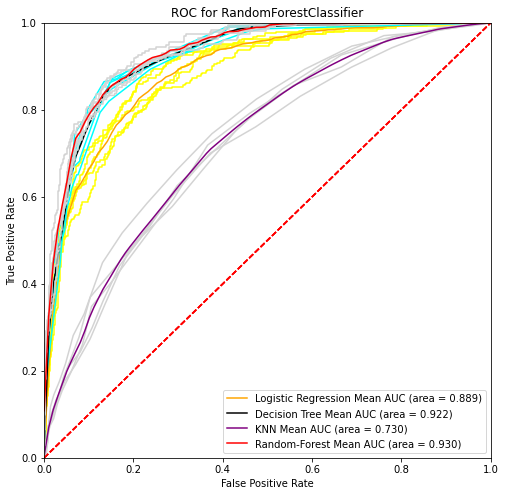

In [57]:
def my_kfold_func(clf ,my_X , y , meancolor , lightcolor , name):

    if(name== 'Decision Tree'):
        my_X = my_X[names[0:13]]
    mae_train = []
    mae_validation = []



    kfold = KFold(n_splits=5, shuffle=True)
    mean_tpr_t = mean_tpr_v = 0.0
    mean_fpr_t = mean_fpr_v = np.linspace(0, 1, 100)

    for train, validation in kfold.split(my_X):
        X_t, X_v, y_t, y_v = my_X.iloc[train], my_X.iloc[validation],y.iloc[train], y.iloc[validation]
             
        clf.fit(X_t, y_t)

        y_prob_t = clf.predict_proba(X_t)[:, 1]
        y_prob_v = clf.predict_proba(X_v)[:, 1]

        fpr_t, tpr_t, _ = roc_curve(y_t, y_prob_t)
        fpr_v, tpr_v, _ = roc_curve(y_v, y_prob_v)

        mean_tpr_t += np.interp(mean_fpr_t, fpr_t, tpr_t)
        mean_tpr_v += np.interp(mean_fpr_v, fpr_v, tpr_v)

        plt.plot(fpr_v, tpr_v, color= lightcolor)

        y_train_pred = clf.predict(X_t)
        y_validation_pred = clf.predict(X_v)
        mae_train.append(mean_absolute_error(y_t, y_train_pred))
        mae_validation.append(mean_absolute_error(y_v, y_validation_pred))

    mean_tpr_t /= 5
    mean_tpr_t[-1] = 1.0
    mean_auc_t = auc(mean_fpr_t, mean_tpr_t)

    mean_tpr_v /= 5
    mean_tpr_v[-1] = 1.0
    mean_auc_v = auc(mean_fpr_v, mean_tpr_v)


    
    plt.plot([0, 1], [0, 1],'r--')
    plt.plot(mean_fpr_v, mean_tpr_v, color = meancolor , linestyle='-', label= name + ' Mean AUC (area = %0.3f)' % mean_auc_v )

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for %s' %str(type(clf)).strip("'>").split(".")[-1])
    plt.legend(loc="lower right")


    is_over = mean_auc_t - mean_auc_v 


    return is_over , mae_train , mae_validation





plt.figure(figsize=(8,8))
#calling the function and combining the graph
of_lr , mae_train_lr , mae_validation_lr = my_kfold_func(LR_clf ,X, y , 'orange' , 'yellow' , 'Logistic Regression')
of_dt ,mae_train_dt , mae_validation_dt = my_kfold_func(clf_DT,X, y , 'black' , 'cyan' , 'Decision Tree')
of_knn  ,mae_train_knn , mae_validation_knn = my_kfold_func(knn_final,X, y , 'purple' , 'lightgray' , 'KNN')
of_rf , mae_train_rf , mae_validation_rf = my_kfold_func(rf_final,X_rf, y_rf , 'red' , 'lightgray' , 'Random-Forest')

### decided no to use - 
#of_ada , mae_train_ada , mae_validation_ada = my_kfold_func(ada_final,X, y , 'red' , 'lightgray' , 'AdaBoost')


plt.show()
        

## Check overfitting for all models
After running the function a few times, we found out that in order to minimize overfitting and underfitting, 3 folds is the best number of folds for all of the models.

### Let's get an indication for over/under fitting of the models - 

In [58]:
def is_overfit(model_name , diff):
    print("The defference between train mean AUC and validation mean AUC for the {} model is: {}".format(model_name , diff))
    if(diff > 0.1):
        print("model is overfitted")
    else:
        print("model is not overfitted")

is_overfit('Logistic Regression' , of_lr)
is_overfit('Decision Tree',of_dt)
is_overfit('KNN', of_knn)
is_overfit('Random Forest' ,of_rf )


### is_overfit('AdaBoost' ,of_ada )


The defference between train mean AUC and validation mean AUC for the Logistic Regression model is: 0.0033145551076573243
model is not overfitted
The defference between train mean AUC and validation mean AUC for the Decision Tree model is: 0.013382307709444041
model is not overfitted
The defference between train mean AUC and validation mean AUC for the KNN model is: 0.04897583316595011
model is not overfitted
The defference between train mean AUC and validation mean AUC for the Random Forest model is: 0.04923875776643394
model is not overfitted


#### We can see that all of our models are not highly overfitted, even though KNN model tends to overfit more then the others.  

# Predicting the test

In [59]:
clf_submission = RandomForestClassifier(random_state=1, **best_params_rf)
clf_submission = clf_submission.fit(X_rf, y_rf)
final_test = impute_data_test[names_rf[0:21]]

result = pd.DataFrame(clf_submission.predict_proba(final_test))
result = pd.DataFrame(result[1]) 

pd.DataFrame(result).to_csv('Submission_group_44.csv',header=["predict_proba"])

# ***************** Pipeline for Random-Forest ********************

In [60]:
def split_data(data):
    if 'id' in data:
        data.drop(columns='id', inplace=True)
    data_numeric = data.select_dtypes(include=['float64' , 'int64','int32']).copy()
    if 'device' in data_numeric:
        data_numeric.drop(columns='device', inplace=True)
    if 'Region' in data:
        data_numeric.drop(columns='Region', inplace=True)
    if 'purchase' in data:
        data_numeric.drop(columns='purchase', inplace=True)
    data_category = data.select_dtypes(include=[np.object_])
    if 'device' in data:
      data_category['device'] = data['device'] 
    if 'Region' in data:  
      data_category['Region'] = data['Region']
    if 'purchase' in data:
      data_category['purchase'] = data['purchase']
    return data_numeric, data_category

def clean_browser(data):
    data_browser = data.copy()
    data_browser.loc[data_browser['internet_browser'].str.contains('chrome' , na = False), 'internet_browser'] = 'chrome'

    data_browser.loc[data_browser['internet_browser'].str.contains('safari' , na = False), 'internet_browser'] = 'safari'

    data_browser.loc[data_browser['internet_browser'].str.contains('edge' , na = False), 'internet_browser'] = 'edge'

    data_browser.loc[data_browser['internet_browser'].str.contains('browser' , na = False), 'internet_browser'] = 'browser_v'
    return data_browser

def data_rep(data):
    data['info_page_duration'] = data['info_page_duration'].str.replace('minutes','')
    data['product_page_duration'] = data['product_page_duration'].str.replace('minutes','')
    data['info_page_duration'] = data['info_page_duration'].astype(float)
    data['product_page_duration'] = data['product_page_duration'].astype(float)

def drop_from_data(data1 , feat):    
    data1 = data1.drop(columns=str(feat), axis=1)
    return data1

def rem_out(data , col):
    df = data[[col]].copy()
    df = df.dropna()
    out_L_index = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)].index 
    rows_no_outl_index = data.iloc[out_L_index, :].index

    row_index = df.drop(rows_no_outl_index).index
    data_clean = data.drop(row_index).copy()
    return data_clean

def clean_with_thrash(data , thr):
    thresh = np.nanpercentile(data['PageValues'],[float(thr)])  
    thresh2 = np.nanpercentile(data['num_of_admin_pages'],[float(thr)])
    thresh3 = np.nanpercentile(data['num_of_product_pages'],[float(thr)])
    
    data = data[data['PageValues'] <= float(thresh)]
    data = data[data['num_of_admin_pages'] <= float(thresh2)]
    data = data[data['num_of_product_pages'] <= float(thresh3)]

    return data

def fill_na_data(data_c , data_category , data_numeric , test = False):

        if(test == False):

            data_numeric1 = drop_from_data(data_numeric , 'D')

        # categorical columns
        data.fillna(data_category.select_dtypes(include='object').mode().iloc[0], inplace=True)
        data_c[['Region','internet_browser','device']] = data_c[['Region','internet_browser','device']].fillna(data[['Region','internet_browser','device']].mode().iloc[0])

        if(test == False):

            data_numeric1 = drop_from_data(data_numeric , 'D')
        # numeric columns
            colist = list(data_numeric1.columns)
            data_c[colist] = data_c[colist].fillna(data[colist].median())
        else:
             # numeric columns
            colist = list(data_numeric.columns)
            data_c[colist] = data_c[colist].fillna(data[colist].median())

def data_eng(data):
    data['Weekend'] = data['Weekend'].astype(int)
    data["Weekend*closeness_to_holiday"] = data['Weekend'] * data["closeness_to_holiday"]
    data["total_num_of_pages"] = data['num_of_admin_pages'] + data["num_of_info_pages"]+ data["num_of_product_pages"]

def get_redundent(data ,test , col , num_of_vals , num_of_vals_A_test = None):
    mydata = data.copy()
    mydata['device'] = mydata.device.astype('string')

    mytest = test.copy()
    mytest['device'] = mytest.device.astype('string')
    item_lst = []

    for item in num_of_vals.items():
        if((item[1] < 200)):
            item_lst.append(item[0])
            mydata.loc[mydata[col].str.contains(str(item[0]) , na = False), str(col)] = 'other'
            mytest.loc[mytest[col].str.contains(str(item[0]) , na = False), str(col)] = 'other'

    if(col == 'A'):
        for item in num_of_vals_A_test.items():
            if(item[0] not in num_of_vals):
                mytest.loc[mytest[col].str.contains(str(item[0]) , na = False), str(col)] = 'other'        

    
    mydata['device'] = mydata.device.astype('category')
    mytest['device'] = mytest.device.astype('category')

    return mydata , mytest



data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

data = clean_browser(data)
test_data = clean_browser(test_data)
data_rep(data)
data_rep(test_data)
data = drop_from_data(data , 'total_duration')
test_data = drop_from_data(test_data , 'total_duration')
data = drop_from_data(data , 'BounceRates')
test_data = drop_from_data(test_data , 'BounceRates')
data = drop_from_data(data , 'product_page_duration')
test_data = drop_from_data(test_data , 'product_page_duration')
data['Weekend'] = data['Weekend'].fillna(0) 
data['Weekend'] = data['Weekend'].astype(int)
data = rem_out(data , 'B')
data = clean_with_thrash(data , 99.993)
data_numeric, data_category=split_data(data)
fill_na_data(data,data_category,data_numeric)
fill_na_data(test_data,data_category,data_numeric , test=True)
uniq_A = data['A'].nunique()
uniq_dev = data['device'].nunique()
num_of_vals_dev = data['device'].value_counts()
num_of_vals_A = data['A'].value_counts()
num_of_vals_A_test = test_data['A'].value_counts()
data , test_data = get_redundent(data ,test_data , 'A', num_of_vals_A , num_of_vals_A_test)
data , test_data = get_redundent(data ,test_data, 'device' , num_of_vals_dev )
data_numeric, data_category=split_data(data)
data[data_numeric.columns]=(data[data_numeric.columns]-data[data_numeric.columns].min())/(data[data_numeric.columns].max()-data[data_numeric.columns].min())
test_data[data_numeric.columns]=(test_data[data_numeric.columns]-test_data[data_numeric.columns].min())/(test_data[data_numeric.columns].max()-test_data[data_numeric.columns].min())
data_numeric, data_category=split_data(data)
test_data_numeric, test_data_category=split_data(test_data)
data = pd.get_dummies(data,columns=['Month','internet_browser','user_type','A','C','device','Region'],drop_first=True)
test_data = pd.get_dummies(test_data,columns=['Month','internet_browser','user_type','A','C','device','Region'],drop_first=True)
data_eng(data)
data_eng(test_data)
### create an imputer for train data
imputer = KNNImputer(n_neighbors=10 , weights = 'distance')
####
X_impu=data.drop(columns="purchase")
y_impu=data["purchase"]
### create a copy of the data witout labels so we dont use it to impute missing values of D 
### fit and tranform new data to fill nan values for D 
impute_data = pd.DataFrame(imputer.fit_transform(X_impu, y=y_impu), columns=X_impu.columns)
## replace D values of old data with imputed ones 
### use train data without labels to fit new imputer 
test_imputer = KNNImputer(n_neighbors=10 , weights = 'distance')
test_imputer =test_imputer.fit(X_impu)
### impute missing test data 
impute_data_test = pd.DataFrame(test_imputer.transform(test_data), columns=test_data.columns)
#### Model #####
X = impute_data
y = y_impu
X_train, X_Validation, y_train, y_Validation = train_test_split(X, y, test_size=0.25,random_state = 1,shuffle = True) 
#finding the best parameters for the model
random_forest_params = {'n_estimators': [ 200 , 250 ] , 
 'criterion' : ['gini', 'entropy'],
 'max_features': ['log2', 'sqrt' , None],
 'min_samples_split': [ 5 , 10],
 'min_samples_leaf': [5,10]
 }



clf_rf= RandomForestClassifier()

# run grid search
grid_rf = GridSearchCV(clf_rf, random_forest_params, cv=5, scoring='roc_auc' , n_jobs=4)
grid_rf.fit(X,y)
best_params_rf = grid_rf.best_params_

rf_final =  RandomForestClassifier( **best_params_rf )
rf_final.fit(X_train,y_train)

#model
model = rf_final
importances = model.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
# Rearrange feature names so they match the sorted feature importances
names_rf = X_train.columns[indices]
most_important_rf = np.sort(importances)[::-1]

X_rf ,y_rf  = X_train[names_rf[0:21]] ,y_train 
clf_submission = RandomForestClassifier(random_state=1, **best_params_rf)
clf_submission = clf_submission.fit(X_rf, y_rf)
final_test = impute_data_test[names_rf[0:21]]

result = pd.DataFrame(clf_submission.predict_proba(final_test))
result = pd.DataFrame(result[1]) 

pd.DataFrame(result).to_csv('Submission_group_44.csv',header=["predict_proba"])
